# 09 — Multi-Seed Comparison: Multi-Task vs Single-Task

Validasi statistik untuk membandingkan **multi-task** (Wang et al., 2021) vs **single-task** (IndoBERT + CRF).

Sebelumnya semua eksperimen pakai seed=42. Dengan val set 368 sampel, selisih F1 0.014 bisa dari random variance.
Notebook ini menjalankan kedua model dengan **3 seed berbeda** untuk mendapat mean ± std yang reliable.

**Referensi hasil sebelumnya:**
| Model | Seed 42 F1 |
|---|---|
| Penelitian sebelumnya (EMC-GCN) | ~0.69 |
| Multi-task (NB 03, λ=0.3) | 0.7410 |
| Single-task (NB 07) | 0.7551 |

**Setup per run:**
- Multi-task: Paper-aligned (λ1=λ2=0.3, Phase1=3, Phase2=15, 18 ep total)
- Single-task: IndoBERT + CRF (18 ep)
- Keduanya: Dropout=0.1, WD=0.01, No freeze, early stopping patience=5
- 3 seeds × 2 models = **6 runs** (~5-6 jam total)

In [1]:
import json
import os
import string
import time
import gc
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import classification_report, f1_score as seq_f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
POS_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_positive.tsv')
NEG_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_negative.tsv')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training config
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4
NUM_EPOCHS = 18
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
DROPOUT = 0.1
IGNORE_INDEX = -100

# Multi-task specific
LAMBDA1 = 0.3
LAMBDA2 = 0.3
PHASE1_EPOCHS = 3
MAX_REL_POS = 20
PATIENCE = 5

# Seeds
SEEDS = [42, 123, 456]

print(f'Seeds: {SEEDS}')
print(f'Models per seed: 2 (multi-task + single-task)')
print(f'Total runs: {len(SEEDS) * 2}')
print(f'Estimated time: ~{len(SEEDS) * 2} hours')

Seeds: [42, 123, 456]
Models per seed: 2 (multi-task + single-task)
Total runs: 6
Estimated time: ~6 hours


### 2. LOAD DATA & TOKENIZER

In [3]:
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

def load_lexicon(path):
    words = set()
    with open(path, 'r', encoding='utf-8') as f:
        next(f)
        for line in f:
            parts = line.strip().split('\t')
            if parts:
                word = parts[0].strip().lower()
                if ' ' not in word and len(word) > 1:
                    words.add(word)
    return words

pos_lexicon = load_lexicon(POS_LEX_PATH)
neg_lexicon = load_lexicon(NEG_LEX_PATH)
overlap = pos_lexicon & neg_lexicon
pos_lexicon -= overlap
neg_lexicon -= overlap

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f'Data: {len(raw_data)} | Pos lex: {len(pos_lexicon)} | Neg lex: {len(neg_lexicon)}')

Data: 2451 | Pos lex: 2288 | Neg lex: 5025


### 3. LABELS & DATA PREPARATION FUNCTIONS

In [4]:
ate_labels = ['O', 'B', 'I', 'E', 'S']
sld_labels = ['O', 'POS', 'NEG']
asd_labels = ['O', 'POS', 'NEG', 'NEU']
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

ate_label2id = {l: i for i, l in enumerate(ate_labels)}
sld_label2id = {l: i for i, l in enumerate(sld_labels)}
asd_label2id = {l: i for i, l in enumerate(asd_labels)}
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}


def prepare_multitask_data(raw_data, tokenizer, pos_lexicon, neg_lexicon):
    """Prepare data for multi-task model (all labels + prior)."""
    # Prior embedding
    word_ate_freq = {}
    for d in raw_data:
        for tok, lab in zip(d['tokens'], d['labels']):
            tok_lower = tok.lower()
            if tok_lower not in word_ate_freq:
                word_ate_freq[tok_lower] = [0] * len(ate_labels)
            if lab == 'O':
                word_ate_freq[tok_lower][ate_label2id['O']] += 1
            else:
                word_ate_freq[tok_lower][ate_label2id[lab.split('-')[0]]] += 1

    default_prior = [1.0] + [0.0] * (len(ate_labels) - 1)
    word_prior = {}
    for word, counts in word_ate_freq.items():
        total = sum(counts)
        word_prior[word] = [c / total for c in counts] if total > 0 else default_prior

    all_input_ids, all_attention_mask = [], []
    all_ate, all_sld, all_asd, all_bieos, all_crf, all_prior = [], [], [], [], [], []

    for d in raw_data:
        tokens, labels = d['tokens'], d['labels']
        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        ate_w, sld_w, asd_w = [], [], []
        for tok, lab in zip(tokens, labels):
            if lab == 'O':
                ate_w.append('O'); asd_w.append('O')
            else:
                prefix, sentiment = lab.split('-', 1)
                ate_w.append(prefix); asd_w.append(sentiment)
            t_clean = tok.lower().strip(string.punctuation)
            if t_clean in pos_lexicon:
                sld_w.append('POS')
            elif t_clean in neg_lexicon:
                sld_w.append('NEG')
            else:
                sld_w.append('O')

        ate_a, sld_a, asd_a, bieos_a, crf_a, prior_a = [], [], [], [], [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(0); prior_a.append(default_prior)
            elif wid != prev_wid:
                if wid < len(tokens):
                    ate_a.append(ate_label2id[ate_w[wid]])
                    sld_a.append(sld_label2id[sld_w[wid]])
                    asd_a.append(asd_label2id[asd_w[wid]])
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                    prior_a.append(word_prior.get(tokens[wid].lower(), default_prior))
                else:
                    ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                    asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                    crf_a.append(0); prior_a.append(default_prior)
            else:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
                prior_a.append(word_prior.get(tokens[wid].lower(), default_prior) if wid < len(tokens) else default_prior)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_ate.append(torch.tensor(ate_a, dtype=torch.long))
        all_sld.append(torch.tensor(sld_a, dtype=torch.long))
        all_asd.append(torch.tensor(asd_a, dtype=torch.long))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))
        all_prior.append(torch.tensor(prior_a, dtype=torch.float))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'ate_labels': torch.stack(all_ate),
        'sld_labels': torch.stack(all_sld),
        'asd_labels': torch.stack(all_asd),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
        'prior_probs': torch.stack(all_prior),
    }


def prepare_singletask_data(raw_data, tokenizer):
    """Prepare data for single-task model (bieos + crf only)."""
    all_input_ids, all_attention_mask, all_bieos, all_crf = [], [], [], []

    for d in raw_data:
        tokens, labels = d['tokens'], d['labels']
        enc = tokenizer(tokens, is_split_into_words=True,
                        max_length=MAX_LENGTH, padding='max_length',
                        truncation=True, return_tensors='pt')
        word_ids = enc.word_ids(batch_index=0)

        bieos_a, crf_a = [], []
        prev_wid = None
        for wid in word_ids:
            if wid is None:
                bieos_a.append(IGNORE_INDEX); crf_a.append(0)
            elif wid != prev_wid:
                if wid < len(tokens):
                    bieos_a.append(bieos_label2id[labels[wid]])
                    crf_a.append(bieos_label2id[labels[wid]])
                else:
                    bieos_a.append(IGNORE_INDEX); crf_a.append(0)
            else:
                bieos_a.append(IGNORE_INDEX)
                crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
            prev_wid = wid

        all_input_ids.append(enc['input_ids'].squeeze(0))
        all_attention_mask.append(enc['attention_mask'].squeeze(0))
        all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
        all_crf.append(torch.tensor(crf_a, dtype=torch.long))

    return {
        'input_ids': torch.stack(all_input_ids),
        'attention_mask': torch.stack(all_attention_mask),
        'bieos_labels': torch.stack(all_bieos),
        'crf_labels': torch.stack(all_crf),
    }


# Prepare both datasets once (tokenization doesn't depend on seed)
print('Preparing multi-task data...')
mt_data_dict = prepare_multitask_data(raw_data, tokenizer, pos_lexicon, neg_lexicon)
print('Preparing single-task data...')
st_data_dict = prepare_singletask_data(raw_data, tokenizer)
print(f'Done. MT keys: {list(mt_data_dict.keys())}')
print(f'       ST keys: {list(st_data_dict.keys())}')

Preparing multi-task data...
Preparing single-task data...
Done. MT keys: ['input_ids', 'attention_mask', 'ate_labels', 'sld_labels', 'asd_labels', 'bieos_labels', 'crf_labels', 'prior_probs']
       ST keys: ['input_ids', 'attention_mask', 'bieos_labels', 'crf_labels']


### 4. DATASET & MODEL CLASSES

In [5]:
class ABSADataset(Dataset):
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}
    def __len__(self):
        return self.data['input_ids'].size(0)
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# ---- Multi-Task Model ----
class CrossAttentionASD(nn.Module):
    def __init__(self, dim, max_relative_position=20):
        super().__init__()
        self.max_rel_pos = max_relative_position
        self.pos_embedding = nn.Embedding(2 * max_relative_position + 1, dim)
        self.W_ae = nn.Linear(dim, dim, bias=False)
        self.W_sl = nn.Linear(dim, dim, bias=False)
        self.W_pos = nn.Linear(dim, dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.w_s = nn.Linear(dim, 1, bias=False)

    def forward(self, h_ae, h_sl, mask=None):
        batch, seq_len, dim = h_ae.shape
        pos = torch.arange(seq_len, device=h_ae.device)
        rel_pos = (pos.unsqueeze(0) - pos.unsqueeze(1)).clamp(
            -self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
        p_ij = self.pos_embedding(rel_pos)
        s_ae = self.W_ae(h_ae)
        s_sl = self.W_sl(h_sl)
        s_pos = self.W_pos(p_ij)
        combined = s_ae.unsqueeze(2) + s_sl.unsqueeze(1) + s_pos.unsqueeze(0) + self.bias
        scores = self.w_s(torch.tanh(combined)).squeeze(-1)
        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))
        attn_weights = torch.softmax(scores, dim=-1)
        return torch.bmm(attn_weights, h_sl)


class HierarchicalMultiTaskABSA(nn.Module):
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.1, max_relative_position=20,
                 lambda1=0.3, lambda2=0.3):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.ate_proj = nn.Sequential(nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)
        self.sld_proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)
        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)
        self.final_proj = nn.Sequential(nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        if prior_probs is not None:
            h_with_prior = torch.cat([h, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h, torch.zeros(*h.shape[:-1], self.ate_classifier.out_features, device=h.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)
        h_sl = self.sld_proj(h)
        sld_logits = self.sld_classifier(h_sl)
        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)
        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))
        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}
        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))
            loss_asd = ce(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))
            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}
        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        with torch.no_grad():
            n = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n].copy_(self.sld_classifier.weight.data[:n])
            self.asd_classifier.bias.data[:n].copy_(self.sld_classifier.bias.data[:n])


# ---- Single-Task Model ----
class SingleTaskABSA(nn.Module):
    def __init__(self, model_name, num_labels, proj_dim=256, dropout=0.1):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size
        self.proj = nn.Sequential(nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.emission = nn.Linear(proj_dim, num_labels)
        self.crf = CRF(num_labels, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, crf_labels=None, bieos_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)
        emissions = self.emission(self.proj(h))
        outputs = {'emissions': emissions}
        if crf_labels is not None:
            mask = attention_mask.bool()
            outputs['loss'] = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')
        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())


print('Model classes defined.')

Model classes defined.


### 5. TRAINING & EVALUATION FUNCTIONS

In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()
            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']
            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)
    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds)
    return avg_loss, f1, all_true, all_preds


def fmt_time(seconds):
    """Format seconds to human readable string."""
    if seconds < 60:
        return f'{seconds:.0f}s'
    elif seconds < 3600:
        return f'{seconds/60:.1f}m'
    else:
        h = int(seconds // 3600)
        m = int((seconds % 3600) // 60)
        return f'{h}h{m:02d}m'


def train_model(model, train_loader, val_loader, device, num_epochs, patience,
                phase1_epochs=0, desc_prefix='', run_idx=0, total_runs=6,
                global_start_time=None):
    """Generic training loop for both model types."""
    bert_params = list(model.bert.named_parameters())
    head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert')]
    total_epochs = phase1_epochs + num_epochs
    total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_epochs
    warmup_steps = int(total_steps * WARMUP_RATIO)

    optimizer = torch.optim.AdamW([
        {'params': [p for _, p in bert_params], 'lr': LR_BERT},
        {'params': [p for _, p in head_params], 'lr': LR_HEAD},
    ], weight_decay=WEIGHT_DECAY)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_f1 = 0
    best_epoch = 0
    patience_counter = 0
    best_state = None
    has_subtasks = hasattr(model, 'apply_sentiment_connection')  # multi-task model
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    if has_subtasks:
        history.update({'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []})
    epoch_times = []

    def elapsed_total_str():
        if global_start_time is not None:
            return f' | Elapsed: {fmt_time(time.time() - global_start_time)}'
        return ''

    def run_epoch(epoch_num, epoch_label):
        model.train()
        epoch_loss = 0
        epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0} if has_subtasks else None
        optimizer.zero_grad()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                    desc=f'  {desc_prefix} {epoch_label}', leave=False)
        for step, batch in pbar:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs['loss'] / GRADIENT_ACCUMULATION
            loss.backward()
            if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            epoch_loss += outputs['loss'].item()
            if epoch_comp is not None and 'losses' in outputs:
                for k in epoch_comp:
                    epoch_comp[k] += outputs['losses'][k].item()
            pbar.set_postfix({'loss': f'{epoch_loss/(step+1):.4f}'})
        pbar.close()
        n = len(train_loader)
        avg_comp = {k: v / n for k, v in epoch_comp.items()} if epoch_comp else None
        return epoch_loss / n, avg_comp

    def subtask_str(comp):
        if comp is not None:
            return (f'\n      ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
                    f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')
        return ''

    # Phase 1 (multi-task only)
    if phase1_epochs > 0 and has_subtasks:
        for ep in range(phase1_epochs):
            ep_t0 = time.time()
            train_loss, comp = run_epoch(ep + 1, f'P1 {ep+1}/{phase1_epochs}')
            val_loss, val_f1, _, _ = evaluate(model, val_loader, device)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(val_f1)
            if comp:
                for k in comp:
                    history[f'loss_{k}'].append(comp[k])
            ep_elapsed = time.time() - ep_t0
            epoch_times.append(ep_elapsed)

            # ETA for this run
            done_ep = len(epoch_times)
            avg_ep = sum(epoch_times) / done_ep
            remaining_ep = total_epochs - done_ep
            eta_run = avg_ep * remaining_ep

            # ETA total (remaining runs)
            remaining_runs = total_runs - run_idx - 1
            eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)

            print(f'    P1 {ep+1}/{phase1_epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | '
                  f'F1: {val_f1:.4f} | {fmt_time(ep_elapsed)}/ep | '
                  f'ETA run: {fmt_time(eta_run)} | ETA all: {fmt_time(eta_total)}'
                  f'{elapsed_total_str()}{subtask_str(comp)}', flush=True)
        model.apply_sentiment_connection()
        print(f'    Sentiment Connection applied', flush=True)

    # Phase 2 / Main training
    for ep in range(num_epochs):
        global_ep = phase1_epochs + ep + 1

        ep_t0 = time.time()
        train_loss, comp = run_epoch(global_ep, f'Ep {global_ep}/{total_epochs}')
        val_loss, val_f1, _, _ = evaluate(model, val_loader, device)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        if comp:
            for k in comp:
                history[f'loss_{k}'].append(comp[k])
        ep_elapsed = time.time() - ep_t0
        epoch_times.append(ep_elapsed)

        improved = val_f1 > best_f1
        if improved:
            best_f1 = val_f1
            best_epoch = global_ep
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        # ETA for this run
        done_ep = len(epoch_times)
        avg_ep = sum(epoch_times) / done_ep
        remaining_ep = total_epochs - done_ep
        if patience_counter > 0:
            remaining_ep = min(remaining_ep, patience - patience_counter)
        eta_run = avg_ep * max(remaining_ep, 0)

        # ETA total (remaining runs)
        remaining_runs = total_runs - run_idx - 1
        eta_total = eta_run + (remaining_runs * avg_ep * total_epochs)

        print(f'    Ep {global_ep:2d}/{total_epochs} | Train: {train_loss:.4f} | '
              f'Val: {val_loss:.4f} | F1: {val_f1:.4f} {"*" if improved else " "} | '
              f'{fmt_time(ep_elapsed)}/ep | ETA run: {fmt_time(eta_run)} | '
              f'ETA all: {fmt_time(eta_total)}{elapsed_total_str()}{subtask_str(comp)}',
              flush=True)

        if patience_counter >= patience:
            print(f'    Early stopped at epoch {global_ep}', flush=True)
            break

    # Final eval with best weights
    if best_state is not None:
        model.load_state_dict(best_state)
    _, final_f1, all_true, all_preds = evaluate(model, val_loader, device)
    report = classification_report(all_true, all_preds)

    return {
        'best_f1': best_f1,
        'best_epoch': best_epoch,
        'epochs_trained': len(history['val_f1']),
        'history': history,
        'report': report,
        'val_true': all_true,
        'val_preds': all_preds,
    }


print('Training functions defined.')

Training functions defined.


### 6. RUN ALL SEEDS

Untuk setiap seed: train multi-task, lalu single-task. Total 6 runs (~5-6 jam).

In [7]:
all_results = {'multi_task': [], 'single_task': []}
total_runs = len(SEEDS) * 2
run_counter = 0
global_start = time.time()
run_times = []  # track elapsed time per run for ETA

print(f'Starting {len(SEEDS)} seeds x 2 models = {total_runs} runs')
print(f'Time: {datetime.now().strftime("%H:%M:%S")}\n')

for seed_idx, seed in enumerate(SEEDS):
    print(f'\n{"#"*60}')
    print(f'SEED {seed} ({seed_idx+1}/{len(SEEDS)})')
    print(f'{"#"*60}')

    # Split data with this seed
    total = len(raw_data)
    indices = torch.randperm(total, generator=torch.Generator().manual_seed(seed))
    split_idx = int(total * TRAIN_RATIO)

    # ---- MULTI-TASK ----
    elapsed_so_far = time.time() - global_start
    print(f'\n  [{run_counter+1}/{total_runs}] Multi-Task seed={seed} | '
          f'{datetime.now().strftime("%H:%M:%S")} | Elapsed total: {fmt_time(elapsed_so_far)}')
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    mt_train = ABSADataset(mt_data_dict, indices[:split_idx])
    mt_val = ABSADataset(mt_data_dict, indices[split_idx:])
    mt_train_loader = DataLoader(mt_train, batch_size=BATCH_SIZE, shuffle=True)
    mt_val_loader = DataLoader(mt_val, batch_size=BATCH_SIZE * 2)

    mt_model = HierarchicalMultiTaskABSA(
        model_name=MODEL_NAME, num_ate=len(ate_labels), num_sld=len(sld_labels),
        num_asd=len(asd_labels), num_final=len(bieos_labels),
        proj_dim=PROJ_DIM, dropout=DROPOUT, max_relative_position=MAX_REL_POS,
        lambda1=LAMBDA1, lambda2=LAMBDA2,
    ).to(device)

    t0 = time.time()
    mt_result = train_model(
        mt_model, mt_train_loader, mt_val_loader, device,
        num_epochs=NUM_EPOCHS - PHASE1_EPOCHS, patience=PATIENCE,
        phase1_epochs=PHASE1_EPOCHS, desc_prefix=f'MT-s{seed}',
        run_idx=run_counter, total_runs=total_runs,
        global_start_time=global_start)
    mt_result['seed'] = seed
    mt_result['elapsed_min'] = (time.time() - t0) / 60
    all_results['multi_task'].append(mt_result)
    run_times.append(time.time() - t0)
    run_counter += 1

    # Overall ETA
    avg_run = sum(run_times) / len(run_times)
    remaining_runs = total_runs - run_counter
    eta_overall = avg_run * remaining_runs

    print(f'  MT seed={seed}: F1={mt_result["best_f1"]:.4f} (ep {mt_result["best_epoch"]}) | '
          f'Run: {fmt_time(run_times[-1])} | Remaining: {remaining_runs} runs ~{fmt_time(eta_overall)}')

    del mt_model, mt_train_loader, mt_val_loader
    gc.collect()
    torch.cuda.empty_cache()

    # ---- SINGLE-TASK ----
    elapsed_so_far = time.time() - global_start
    print(f'\n  [{run_counter+1}/{total_runs}] Single-Task seed={seed} | '
          f'{datetime.now().strftime("%H:%M:%S")} | Elapsed total: {fmt_time(elapsed_so_far)}')
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    st_train = ABSADataset(st_data_dict, indices[:split_idx])
    st_val = ABSADataset(st_data_dict, indices[split_idx:])
    st_train_loader = DataLoader(st_train, batch_size=BATCH_SIZE, shuffle=True)
    st_val_loader = DataLoader(st_val, batch_size=BATCH_SIZE * 2)

    st_model = SingleTaskABSA(
        model_name=MODEL_NAME, num_labels=len(bieos_labels),
        proj_dim=PROJ_DIM, dropout=DROPOUT,
    ).to(device)

    t0 = time.time()
    st_result = train_model(
        st_model, st_train_loader, st_val_loader, device,
        num_epochs=NUM_EPOCHS, patience=PATIENCE,
        phase1_epochs=0, desc_prefix=f'ST-s{seed}',
        run_idx=run_counter, total_runs=total_runs,
        global_start_time=global_start)
    st_result['seed'] = seed
    st_result['elapsed_min'] = (time.time() - t0) / 60
    all_results['single_task'].append(st_result)
    run_times.append(time.time() - t0)
    run_counter += 1

    # Overall ETA
    avg_run = sum(run_times) / len(run_times)
    remaining_runs = total_runs - run_counter
    eta_overall = avg_run * remaining_runs

    print(f'  ST seed={seed}: F1={st_result["best_f1"]:.4f} (ep {st_result["best_epoch"]}) | '
          f'Run: {fmt_time(run_times[-1])} | Remaining: {remaining_runs} runs ~{fmt_time(eta_overall)}')

    del st_model, st_train_loader, st_val_loader
    gc.collect()
    torch.cuda.empty_cache()

    # Intermediate save
    torch.save(all_results, os.path.join(MODEL_DIR, 'multiseed_intermediate.pt'))
    print(f'  >> Intermediate saved (seed {seed} done)')

total_elapsed = time.time() - global_start
print(f'\n{"="*60}')
print(f'ALL RUNS COMPLETED at {datetime.now().strftime("%H:%M:%S")}')
print(f'Total time: {fmt_time(total_elapsed)}')
print(f'{"="*60}')

Starting 3 seeds x 2 models = 6 runs
Time: 14:43:24


############################################################
SEED 42 (1/3)
############################################################

  [1/6] Multi-Task seed=42 | 14:43:24 | Elapsed total: 0s


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  MT-s42 P1 1/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 1/3 | Train: 37.0587 | Val: 16.5333 | F1: 0.0000 | 4.4m/ep | ETA run: 1h14m | ETA all: 7h49m | Elapsed: 4.5m
      ATE:1.053  SLD:0.907  ASD:1.153  CRF:36.125


  MT-s42 P1 2/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 2/3 | Train: 12.2780 | Val: 8.6853 | F1: 0.5684 | 4.4m/ep | ETA run: 1h10m | ETA all: 7h45m | Elapsed: 8.9m
      ATE:0.446  SLD:0.773  ASD:0.574  CRF:11.740


  MT-s42 P1 3/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 3/3 | Train: 7.1887 | Val: 6.5795 | F1: 0.6459 | 4.6m/ep | ETA run: 1h07m | ETA all: 7h50m | Elapsed: 13.5m
      ATE:0.285  SLD:0.751  ASD:0.475  CRF:6.736
    Sentiment Connection applied


  MT-s42 Ep 4/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/18 | Train: 4.3556 | Val: 6.6110 | F1: 0.7243 * | 4.4m/ep | ETA run: 1h02m | ETA all: 7h43m | Elapsed: 17.9m
      ATE:0.190  SLD:0.742  ASD:0.480  CRF:3.932


  MT-s42 Ep 5/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/18 | Train: 2.7382 | Val: 7.3908 | F1: 0.7134   | 4.4m/ep | ETA run: 17.8m | ETA all: 6h57m | Elapsed: 22.3m
      ATE:0.135  SLD:0.732  ASD:0.375  CRF:2.366


  MT-s42 Ep 6/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/18 | Train: 1.7742 | Val: 8.7979 | F1: 0.7025   | 4.4m/ep | ETA run: 13.3m | ETA all: 6h52m | Elapsed: 26.7m
      ATE:0.102  SLD:0.718  ASD:0.318  CRF:1.433


  MT-s42 Ep 7/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/18 | Train: 1.2575 | Val: 9.1953 | F1: 0.7231   | 4.4m/ep | ETA run: 8.9m | ETA all: 6h48m | Elapsed: 31.2m
      ATE:0.079  SLD:0.693  ASD:0.256  CRF:0.949


  MT-s42 Ep 8/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/18 | Train: 0.8794 | Val: 9.8189 | F1: 0.7319 * | 4.8m/ep | ETA run: 44.9m | ETA all: 7h28m | Elapsed: 36.0m
      ATE:0.060  SLD:0.662  ASD:0.164  CRF:0.614


  MT-s42 Ep 9/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/18 | Train: 0.6080 | Val: 11.9043 | F1: 0.7246   | 4.5m/ep | ETA run: 18.0m | ETA all: 7h02m | Elapsed: 40.5m
      ATE:0.045  SLD:0.622  ASD:0.083  CRF:0.383


  MT-s42 Ep 10/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/18 | Train: 0.5283 | Val: 12.3129 | F1: 0.7392 * | 4.4m/ep | ETA run: 35.9m | ETA all: 7h19m | Elapsed: 44.9m
      ATE:0.037  SLD:0.581  ASD:0.054  CRF:0.327


  MT-s42 Ep 11/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/18 | Train: 0.3916 | Val: 12.6678 | F1: 0.7397 * | 4.4m/ep | ETA run: 31.3m | ETA all: 7h14m | Elapsed: 49.4m
      ATE:0.026  SLD:0.528  ASD:0.038  CRF:0.214


  MT-s42 Ep 12/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/18 | Train: 0.3007 | Val: 13.5938 | F1: 0.7314   | 4.4m/ep | ETA run: 17.9m | ETA all: 6h59m | Elapsed: 53.7m
      ATE:0.019  SLD:0.481  ASD:0.034  CRF:0.141


  MT-s42 Ep 13/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/18 | Train: 0.2428 | Val: 14.1325 | F1: 0.7341   | 4.4m/ep | ETA run: 13.4m | ETA all: 6h54m | Elapsed: 58.1m
      ATE:0.015  SLD:0.398  ASD:0.028  CRF:0.111


  MT-s42 Ep 14/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/18 | Train: 0.1916 | Val: 14.3426 | F1: 0.7329   | 4.4m/ep | ETA run: 8.9m | ETA all: 6h49m | Elapsed: 1h02m
      ATE:0.012  SLD:0.335  ASD:0.023  CRF:0.081


  MT-s42 Ep 15/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/18 | Train: 0.1518 | Val: 14.4365 | F1: 0.7413 * | 4.4m/ep | ETA run: 13.3m | ETA all: 6h53m | Elapsed: 1h06m
      ATE:0.009  SLD:0.286  ASD:0.019  CRF:0.057


  MT-s42 Ep 16/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/18 | Train: 0.1285 | Val: 14.6439 | F1: 0.7344   | 4.4m/ep | ETA run: 8.9m | ETA all: 6h48m | Elapsed: 1h11m
      ATE:0.008  SLD:0.250  ASD:0.018  CRF:0.046


  MT-s42 Ep 17/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 17/18 | Train: 0.1138 | Val: 14.4874 | F1: 0.7326   | 4.4m/ep | ETA run: 4.4m | ETA all: 6h44m | Elapsed: 1h15m
      ATE:0.007  SLD:0.226  ASD:0.018  CRF:0.038


  MT-s42 Ep 18/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 18/18 | Train: 0.0947 | Val: 14.4732 | F1: 0.7377   | 4.6m/ep | ETA run: 0s | ETA all: 6h40m | Elapsed: 1h20m
      ATE:0.006  SLD:0.209  ASD:0.015  CRF:0.026
  MT seed=42: F1=0.7413 (ep 15) | Run: 1h20m | Remaining: 5 runs ~6h41m

  [2/6] Single-Task seed=42 | 16:03:53 | Elapsed total: 1h20m


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  ST-s42 Ep 1/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  1/18 | Train: 31.8491 | Val: 12.1894 | F1: 0.3732 * | 4.3m/ep | ETA run: 1h13m | ETA all: 6h22m | Elapsed: 1h24m


  ST-s42 Ep 2/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  2/18 | Train: 10.1956 | Val: 7.5602 | F1: 0.5927 * | 4.3m/ep | ETA run: 1h08m | ETA all: 6h17m | Elapsed: 1h29m


  ST-s42 Ep 3/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  3/18 | Train: 5.8851 | Val: 5.7590 | F1: 0.6772 * | 4.3m/ep | ETA run: 1h04m | ETA all: 6h12m | Elapsed: 1h33m


  ST-s42 Ep 4/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/18 | Train: 3.5009 | Val: 6.3742 | F1: 0.7110 * | 4.6m/ep | ETA run: 1h01m | ETA all: 6h16m | Elapsed: 1h38m


  ST-s42 Ep 5/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/18 | Train: 2.0177 | Val: 7.1913 | F1: 0.7104   | 4.4m/ep | ETA run: 17.5m | ETA all: 5h32m | Elapsed: 1h42m


  ST-s42 Ep 6/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/18 | Train: 1.2420 | Val: 8.4929 | F1: 0.7216 * | 4.5m/ep | ETA run: 52.7m | ETA all: 6h09m | Elapsed: 1h46m


  ST-s42 Ep 7/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/18 | Train: 0.8402 | Val: 9.3025 | F1: 0.7248 * | 4.4m/ep | ETA run: 48.4m | ETA all: 6h04m | Elapsed: 1h51m


  ST-s42 Ep 8/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/18 | Train: 0.5457 | Val: 9.9884 | F1: 0.7370 * | 4.3m/ep | ETA run: 43.8m | ETA all: 5h59m | Elapsed: 1h55m


  ST-s42 Ep 9/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/18 | Train: 0.3914 | Val: 10.3882 | F1: 0.7289   | 4.5m/ep | ETA run: 17.6m | ETA all: 5h33m | Elapsed: 2h00m


  ST-s42 Ep 10/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/18 | Train: 0.2833 | Val: 11.8873 | F1: 0.7391 * | 4.3m/ep | ETA run: 35.1m | ETA all: 5h51m | Elapsed: 2h04m


  ST-s42 Ep 11/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/18 | Train: 0.2039 | Val: 12.2328 | F1: 0.7511 * | 4.4m/ep | ETA run: 30.7m | ETA all: 5h46m | Elapsed: 2h08m


  ST-s42 Ep 12/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/18 | Train: 0.1772 | Val: 14.5623 | F1: 0.7242   | 4.4m/ep | ETA run: 17.6m | ETA all: 5h33m | Elapsed: 2h13m


  ST-s42 Ep 13/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/18 | Train: 0.1157 | Val: 13.9110 | F1: 0.7337   | 4.4m/ep | ETA run: 13.2m | ETA all: 5h29m | Elapsed: 2h17m


  ST-s42 Ep 14/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/18 | Train: 0.0657 | Val: 14.4162 | F1: 0.7503   | 4.3m/ep | ETA run: 8.8m | ETA all: 5h24m | Elapsed: 2h22m


  ST-s42 Ep 15/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/18 | Train: 0.0736 | Val: 14.9844 | F1: 0.7460   | 4.4m/ep | ETA run: 4.4m | ETA all: 5h20m | Elapsed: 2h26m


  ST-s42 Ep 16/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/18 | Train: 0.0512 | Val: 15.6375 | F1: 0.7432   | 4.2m/ep | ETA run: 0s | ETA all: 5h15m | Elapsed: 2h30m
    Early stopped at epoch 16
  ST seed=42: F1=0.7511 (ep 11) | Run: 1h10m | Remaining: 4 runs ~5h01m
  >> Intermediate saved (seed 42 done)

############################################################
SEED 123 (2/3)
############################################################

  [3/6] Multi-Task seed=123 | 17:14:22 | Elapsed total: 2h30m


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  MT-s123 P1 1/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 1/3 | Train: 38.2581 | Val: 17.2465 | F1: 0.0000 | 4.3m/ep | ETA run: 1h13m | ETA all: 5h05m | Elapsed: 2h35m
      ATE:1.288  SLD:1.011  ASD:1.122  CRF:37.232


  MT-s123 P1 2/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 2/3 | Train: 12.0503 | Val: 11.1516 | F1: 0.5520 | 4.4m/ep | ETA run: 1h09m | ETA all: 5h04m | Elapsed: 2h39m
      ATE:0.425  SLD:0.772  ASD:0.572  CRF:11.520


  MT-s123 P1 3/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 3/3 | Train: 7.1598 | Val: 7.3337 | F1: 0.6563 | 4.4m/ep | ETA run: 1h05m | ETA all: 5h01m | Elapsed: 2h44m
      ATE:0.255  SLD:0.758  ASD:0.452  CRF:6.720
    Sentiment Connection applied


  MT-s123 Ep 4/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/18 | Train: 4.2093 | Val: 7.8281 | F1: 0.6985 * | 4.4m/ep | ETA run: 1h01m | ETA all: 4h58m | Elapsed: 2h48m
      ATE:0.166  SLD:0.758  ASD:0.467  CRF:3.792


  MT-s123 Ep 5/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/18 | Train: 2.6877 | Val: 9.1227 | F1: 0.6905   | 4.5m/ep | ETA run: 17.6m | ETA all: 4h15m | Elapsed: 2h53m
      ATE:0.117  SLD:0.750  ASD:0.373  CRF:2.316


  MT-s123 Ep 6/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/18 | Train: 1.6955 | Val: 10.7586 | F1: 0.7088 * | 4.4m/ep | ETA run: 52.9m | ETA all: 4h51m | Elapsed: 2h57m
      ATE:0.082  SLD:0.736  ASD:0.305  CRF:1.359


  MT-s123 Ep 7/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/18 | Train: 1.2012 | Val: 11.9269 | F1: 0.7105 * | 4.4m/ep | ETA run: 48.5m | ETA all: 4h46m | Elapsed: 3h01m
      ATE:0.061  SLD:0.716  ASD:0.241  CRF:0.896


  MT-s123 Ep 8/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/18 | Train: 0.8559 | Val: 12.6903 | F1: 0.7113 * | 4.4m/ep | ETA run: 44.1m | ETA all: 4h42m | Elapsed: 3h06m
      ATE:0.048  SLD:0.685  ASD:0.140  CRF:0.594


  MT-s123 Ep 9/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/18 | Train: 0.6911 | Val: 13.9489 | F1: 0.7059   | 4.5m/ep | ETA run: 17.7m | ETA all: 4h15m | Elapsed: 3h10m
      ATE:0.037  SLD:0.638  ASD:0.075  CRF:0.466


  MT-s123 Ep 10/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/18 | Train: 0.4898 | Val: 14.0712 | F1: 0.7266 * | 4.4m/ep | ETA run: 35.3m | ETA all: 4h33m | Elapsed: 3h15m
      ATE:0.026  SLD:0.591  ASD:0.046  CRF:0.291


  MT-s123 Ep 11/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/18 | Train: 0.3590 | Val: 15.3513 | F1: 0.7194   | 4.4m/ep | ETA run: 17.6m | ETA all: 4h15m | Elapsed: 3h19m
      ATE:0.019  SLD:0.516  ASD:0.030  CRF:0.189


  MT-s123 Ep 12/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/18 | Train: 0.3008 | Val: 15.6239 | F1: 0.7135   | 4.4m/ep | ETA run: 13.2m | ETA all: 4h11m | Elapsed: 3h23m
      ATE:0.015  SLD:0.451  ASD:0.027  CRF:0.153


  MT-s123 Ep 13/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/18 | Train: 0.2363 | Val: 15.8284 | F1: 0.7195   | 4.5m/ep | ETA run: 8.8m | ETA all: 4h07m | Elapsed: 3h28m
      ATE:0.011  SLD:0.394  ASD:0.022  CRF:0.108


  MT-s123 Ep 14/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/18 | Train: 0.1815 | Val: 16.3211 | F1: 0.7221   | 4.4m/ep | ETA run: 4.4m | ETA all: 4h02m | Elapsed: 3h32m
      ATE:0.009  SLD:0.333  ASD:0.020  CRF:0.073


  MT-s123 Ep 15/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/18 | Train: 0.1392 | Val: 17.0272 | F1: 0.7202   | 4.4m/ep | ETA run: 0s | ETA all: 3h57m | Elapsed: 3h37m
      ATE:0.007  SLD:0.286  ASD:0.015  CRF:0.047
    Early stopped at epoch 15
  MT seed=123: F1=0.7266 (ep 10) | Run: 1h06m | Remaining: 3 runs ~3h37m

  [4/6] Single-Task seed=123 | 18:20:46 | Elapsed total: 3h37m


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  ST-s123 Ep 1/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  1/18 | Train: 30.9689 | Val: 12.0887 | F1: 0.4607 * | 4.3m/ep | ETA run: 1h12m | ETA all: 3h45m | Elapsed: 3h41m


  ST-s123 Ep 2/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  2/18 | Train: 9.4215 | Val: 7.2159 | F1: 0.6179 * | 4.3m/ep | ETA run: 1h08m | ETA all: 3h42m | Elapsed: 3h46m


  ST-s123 Ep 3/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  3/18 | Train: 5.3743 | Val: 6.1252 | F1: 0.7106 * | 4.3m/ep | ETA run: 1h04m | ETA all: 3h37m | Elapsed: 3h50m


  ST-s123 Ep 4/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/18 | Train: 3.1370 | Val: 7.4494 | F1: 0.6752   | 4.3m/ep | ETA run: 17.1m | ETA all: 2h50m | Elapsed: 3h54m


  ST-s123 Ep 5/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/18 | Train: 1.8682 | Val: 8.3167 | F1: 0.6991   | 4.2m/ep | ETA run: 12.8m | ETA all: 2h46m | Elapsed: 3h58m


  ST-s123 Ep 6/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/18 | Train: 1.1932 | Val: 9.3101 | F1: 0.6953   | 4.1m/ep | ETA run: 8.5m | ETA all: 2h40m | Elapsed: 4h02m


  ST-s123 Ep 7/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/18 | Train: 0.7705 | Val: 10.4567 | F1: 0.6973   | 4.4m/ep | ETA run: 4.2m | ETA all: 2h37m | Elapsed: 4h07m


  ST-s123 Ep 8/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/18 | Train: 0.5642 | Val: 11.5729 | F1: 0.6937   | 3.7m/ep | ETA run: 0s | ETA all: 2h30m | Elapsed: 4h10m
    Early stopped at epoch 8
  ST seed=123: F1=0.7106 (ep 3) | Run: 33.7m | Remaining: 2 runs ~2h05m
  >> Intermediate saved (seed 123 done)

############################################################
SEED 456 (3/3)
############################################################

  [5/6] Multi-Task seed=456 | 18:54:31 | Elapsed total: 4h11m


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  MT-s456 P1 1/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 1/3 | Train: 36.9738 | Val: 15.2211 | F1: 0.0078 | 3.8m/ep | ETA run: 1h04m | ETA all: 2h12m | Elapsed: 4h14m
      ATE:1.165  SLD:1.039  ASD:0.988  CRF:36.016


  MT-s456 P1 2/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 2/3 | Train: 11.9737 | Val: 10.0736 | F1: 0.5567 | 3.8m/ep | ETA run: 1h01m | ETA all: 2h09m | Elapsed: 4h18m
      ATE:0.443  SLD:0.781  ASD:0.569  CRF:11.436


  MT-s456 P1 3/3:   0%|          | 0/521 [00:00<?, ?it/s]

    P1 3/3 | Train: 7.4548 | Val: 7.9743 | F1: 0.6310 | 3.8m/ep | ETA run: 57.2m | ETA all: 2h05m | Elapsed: 4h22m
      ATE:0.278  SLD:0.759  ASD:0.470  CRF:7.003
    Sentiment Connection applied


  MT-s456 Ep 4/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/18 | Train: 4.6307 | Val: 8.4296 | F1: 0.6710 * | 3.5m/ep | ETA run: 52.2m | ETA all: 1h59m | Elapsed: 4h26m
      ATE:0.194  SLD:0.749  ASD:0.487  CRF:4.202


  MT-s456 Ep 5/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/18 | Train: 2.8801 | Val: 8.7871 | F1: 0.6939 * | 3.5m/ep | ETA run: 47.9m | ETA all: 1h54m | Elapsed: 4h29m
      ATE:0.134  SLD:0.741  ASD:0.389  CRF:2.501


  MT-s456 Ep 6/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/18 | Train: 1.9546 | Val: 10.1837 | F1: 0.7091 * | 3.6m/ep | ETA run: 44.1m | ETA all: 1h50m | Elapsed: 4h33m
      ATE:0.098  SLD:0.714  ASD:0.329  CRF:1.613


  MT-s456 Ep 7/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/18 | Train: 1.3971 | Val: 11.5667 | F1: 0.7100 * | 3.6m/ep | ETA run: 40.2m | ETA all: 1h46m | Elapsed: 4h36m
      ATE:0.078  SLD:0.691  ASD:0.247  CRF:1.092


  MT-s456 Ep 8/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/18 | Train: 0.9523 | Val: 12.3523 | F1: 0.7141 * | 3.5m/ep | ETA run: 36.4m | ETA all: 1h41m | Elapsed: 4h40m
      ATE:0.058  SLD:0.653  ASD:0.151  CRF:0.694


  MT-s456 Ep 9/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/18 | Train: 0.7093 | Val: 13.8874 | F1: 0.7240 * | 3.5m/ep | ETA run: 32.6m | ETA all: 1h37m | Elapsed: 4h43m
      ATE:0.045  SLD:0.617  ASD:0.097  CRF:0.482


  MT-s456 Ep 10/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/18 | Train: 0.5349 | Val: 14.6063 | F1: 0.7198   | 3.5m/ep | ETA run: 14.4m | ETA all: 1h19m | Elapsed: 4h47m
      ATE:0.036  SLD:0.584  ASD:0.069  CRF:0.328


  MT-s456 Ep 11/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/18 | Train: 0.4503 | Val: 15.3439 | F1: 0.7255 * | 3.5m/ep | ETA run: 25.2m | ETA all: 1h29m | Elapsed: 4h50m
      ATE:0.026  SLD:0.532  ASD:0.057  CRF:0.266


  MT-s456 Ep 12/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/18 | Train: 0.3319 | Val: 15.9966 | F1: 0.7261 * | 3.5m/ep | ETA run: 21.5m | ETA all: 1h26m | Elapsed: 4h54m
      ATE:0.018  SLD:0.475  ASD:0.046  CRF:0.170


  MT-s456 Ep 13/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/18 | Train: 0.2545 | Val: 16.9652 | F1: 0.7253   | 3.5m/ep | ETA run: 14.3m | ETA all: 1h18m | Elapsed: 4h57m
      ATE:0.014  SLD:0.421  ASD:0.038  CRF:0.113


  MT-s456 Ep 14/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/18 | Train: 0.2006 | Val: 16.7950 | F1: 0.7189   | 3.5m/ep | ETA run: 10.7m | ETA all: 1h15m | Elapsed: 5h01m
      ATE:0.011  SLD:0.350  ASD:0.031  CRF:0.083


  MT-s456 Ep 15/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/18 | Train: 0.1653 | Val: 17.0666 | F1: 0.7277 * | 3.5m/ep | ETA run: 10.7m | ETA all: 1h14m | Elapsed: 5h04m
      ATE:0.009  SLD:0.291  ASD:0.028  CRF:0.067


  MT-s456 Ep 16/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/18 | Train: 0.1234 | Val: 17.7354 | F1: 0.7228   | 3.5m/ep | ETA run: 7.1m | ETA all: 1h11m | Elapsed: 5h08m
      ATE:0.006  SLD:0.254  ASD:0.023  CRF:0.039


  MT-s456 Ep 17/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 17/18 | Train: 0.1214 | Val: 17.6046 | F1: 0.7254   | 3.5m/ep | ETA run: 3.6m | ETA all: 1h07m | Elapsed: 5h11m
      ATE:0.006  SLD:0.225  ASD:0.021  CRF:0.046


  MT-s456 Ep 18/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 18/18 | Train: 0.1056 | Val: 17.4803 | F1: 0.7253   | 3.5m/ep | ETA run: 0s | ETA all: 1h04m | Elapsed: 5h15m
      ATE:0.005  SLD:0.212  ASD:0.019  CRF:0.035
  MT seed=456: F1=0.7277 (ep 15) | Run: 1h04m | Remaining: 1 runs ~1h03m

  [6/6] Single-Task seed=456 | 19:58:50 | Elapsed total: 5h15m


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

  ST-s456 Ep 1/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  1/18 | Train: 33.5563 | Val: 12.4997 | F1: 0.4344 * | 3.5m/ep | ETA run: 59.7m | ETA all: 59.7m | Elapsed: 5h19m


  ST-s456 Ep 2/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  2/18 | Train: 9.6084 | Val: 7.8332 | F1: 0.6314 * | 3.4m/ep | ETA run: 55.5m | ETA all: 55.5m | Elapsed: 5h22m


  ST-s456 Ep 3/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  3/18 | Train: 5.5274 | Val: 6.8528 | F1: 0.6826 * | 3.4m/ep | ETA run: 51.7m | ETA all: 51.7m | Elapsed: 5h25m


  ST-s456 Ep 4/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  4/18 | Train: 3.1760 | Val: 8.0222 | F1: 0.7102 * | 3.4m/ep | ETA run: 48.1m | ETA all: 48.1m | Elapsed: 5h29m


  ST-s456 Ep 5/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  5/18 | Train: 1.8988 | Val: 8.9824 | F1: 0.6957   | 3.5m/ep | ETA run: 13.8m | ETA all: 13.8m | Elapsed: 5h32m


  ST-s456 Ep 6/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  6/18 | Train: 1.1263 | Val: 10.1417 | F1: 0.7028   | 3.6m/ep | ETA run: 10.4m | ETA all: 10.4m | Elapsed: 5h36m


  ST-s456 Ep 7/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  7/18 | Train: 0.7391 | Val: 11.1201 | F1: 0.7135 * | 3.6m/ep | ETA run: 38.3m | ETA all: 38.3m | Elapsed: 5h39m


  ST-s456 Ep 8/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  8/18 | Train: 0.4677 | Val: 12.1361 | F1: 0.7081   | 3.6m/ep | ETA run: 14.0m | ETA all: 14.0m | Elapsed: 5h43m


  ST-s456 Ep 9/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep  9/18 | Train: 0.3907 | Val: 13.3397 | F1: 0.7224 * | 3.5m/ep | ETA run: 31.5m | ETA all: 31.5m | Elapsed: 5h47m


  ST-s456 Ep 10/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 10/18 | Train: 0.2434 | Val: 14.2239 | F1: 0.7208   | 3.5m/ep | ETA run: 14.0m | ETA all: 14.0m | Elapsed: 5h50m


  ST-s456 Ep 11/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 11/18 | Train: 0.1801 | Val: 15.8925 | F1: 0.7126   | 3.4m/ep | ETA run: 10.5m | ETA all: 10.5m | Elapsed: 5h53m


  ST-s456 Ep 12/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 12/18 | Train: 0.1400 | Val: 16.2098 | F1: 0.7267 * | 3.4m/ep | ETA run: 20.9m | ETA all: 20.9m | Elapsed: 5h57m


  ST-s456 Ep 13/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 13/18 | Train: 0.1198 | Val: 17.0704 | F1: 0.7238   | 3.4m/ep | ETA run: 13.9m | ETA all: 13.9m | Elapsed: 6h00m


  ST-s456 Ep 14/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 14/18 | Train: 0.0911 | Val: 17.4462 | F1: 0.7215   | 3.4m/ep | ETA run: 10.4m | ETA all: 10.4m | Elapsed: 6h04m


  ST-s456 Ep 15/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 15/18 | Train: 0.0605 | Val: 17.8249 | F1: 0.7275 * | 3.5m/ep | ETA run: 10.4m | ETA all: 10.4m | Elapsed: 6h07m


  ST-s456 Ep 16/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 16/18 | Train: 0.0348 | Val: 17.9163 | F1: 0.7204   | 3.5m/ep | ETA run: 6.9m | ETA all: 6.9m | Elapsed: 6h11m


  ST-s456 Ep 17/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 17/18 | Train: 0.0405 | Val: 18.2492 | F1: 0.7186   | 3.5m/ep | ETA run: 3.5m | ETA all: 3.5m | Elapsed: 6h14m


  ST-s456 Ep 18/18:   0%|          | 0/521 [00:00<?, ?it/s]

    Ep 18/18 | Train: 0.0367 | Val: 18.3447 | F1: 0.7224   | 3.5m/ep | ETA run: 0s | ETA all: 0s | Elapsed: 6h18m
  ST seed=456: F1=0.7275 (ep 15) | Run: 1h02m | Remaining: 0 runs ~0s
  >> Intermediate saved (seed 456 done)

ALL RUNS COMPLETED at 21:01:44
Total time: 6h18m


### 7. HASIL: MULTI-SEED COMPARISON

In [8]:
mt_f1s = [r['best_f1'] for r in all_results['multi_task']]
st_f1s = [r['best_f1'] for r in all_results['single_task']]

mt_mean, mt_std = np.mean(mt_f1s), np.std(mt_f1s)
st_mean, st_std = np.mean(st_f1s), np.std(st_f1s)

print('=' * 65)
print('MULTI-SEED COMPARISON')
print('=' * 65)

# Per-seed table
print(f'\n{"Seed":>6s} {"Multi-Task":>12s} {"Single-Task":>12s} {"Diff (MT-ST)":>14s}')
print('-' * 46)
for i, seed in enumerate(SEEDS):
    diff = mt_f1s[i] - st_f1s[i]
    winner = 'MT' if diff > 0 else 'ST'
    print(f'{seed:>6d} {mt_f1s[i]:>12.4f} {st_f1s[i]:>12.4f} {diff:>+12.4f}  ({winner})')
print('-' * 46)
print(f'{"Mean":>6s} {mt_mean:>12.4f} {st_mean:>12.4f} {mt_mean - st_mean:>+12.4f}')
print(f'{"Std":>6s} {mt_std:>12.4f} {st_std:>12.4f}')

# Conclusion
print(f'\n{"="*65}')
print('KESIMPULAN')
print(f'{"="*65}')
print(f'Multi-Task  : {mt_mean:.4f} ± {mt_std:.4f}')
print(f'Single-Task : {st_mean:.4f} ± {st_std:.4f}')
print(f'EMC-GCN     : ~0.69 (penelitian sebelumnya)')

gap = abs(mt_mean - st_mean)
overlap = (mt_mean - mt_std) < (st_mean + st_std) and (st_mean - st_std) < (mt_mean + mt_std)

if overlap:
    print(f'\nStd ranges overlap → perbedaan TIDAK signifikan')
    print(f'Multi-task dan single-task perform SEBANDING')
else:
    better = 'Multi-task' if mt_mean > st_mean else 'Single-task'
    print(f'\n{better} secara konsisten lebih baik (+{gap:.4f})')

print(f'\nKedua model mengalahkan EMC-GCN (~0.69) secara signifikan:')
print(f'  Multi-task  vs EMC-GCN: +{mt_mean - 0.69:.4f}')
print(f'  Single-task vs EMC-GCN: +{st_mean - 0.69:.4f}')

MULTI-SEED COMPARISON

  Seed   Multi-Task  Single-Task   Diff (MT-ST)
----------------------------------------------
    42       0.7413       0.7511      -0.0098  (ST)
   123       0.7266       0.7106      +0.0160  (MT)
   456       0.7277       0.7275      +0.0002  (MT)
----------------------------------------------
  Mean       0.7319       0.7297      +0.0021
   Std       0.0067       0.0166

KESIMPULAN
Multi-Task  : 0.7319 ± 0.0067
Single-Task : 0.7297 ± 0.0166
EMC-GCN     : ~0.69 (penelitian sebelumnya)

Std ranges overlap → perbedaan TIDAK signifikan
Multi-task dan single-task perform SEBANDING

Kedua model mengalahkan EMC-GCN (~0.69) secara signifikan:
  Multi-task  vs EMC-GCN: +0.0419
  Single-task vs EMC-GCN: +0.0397


### 8. VISUALISASI

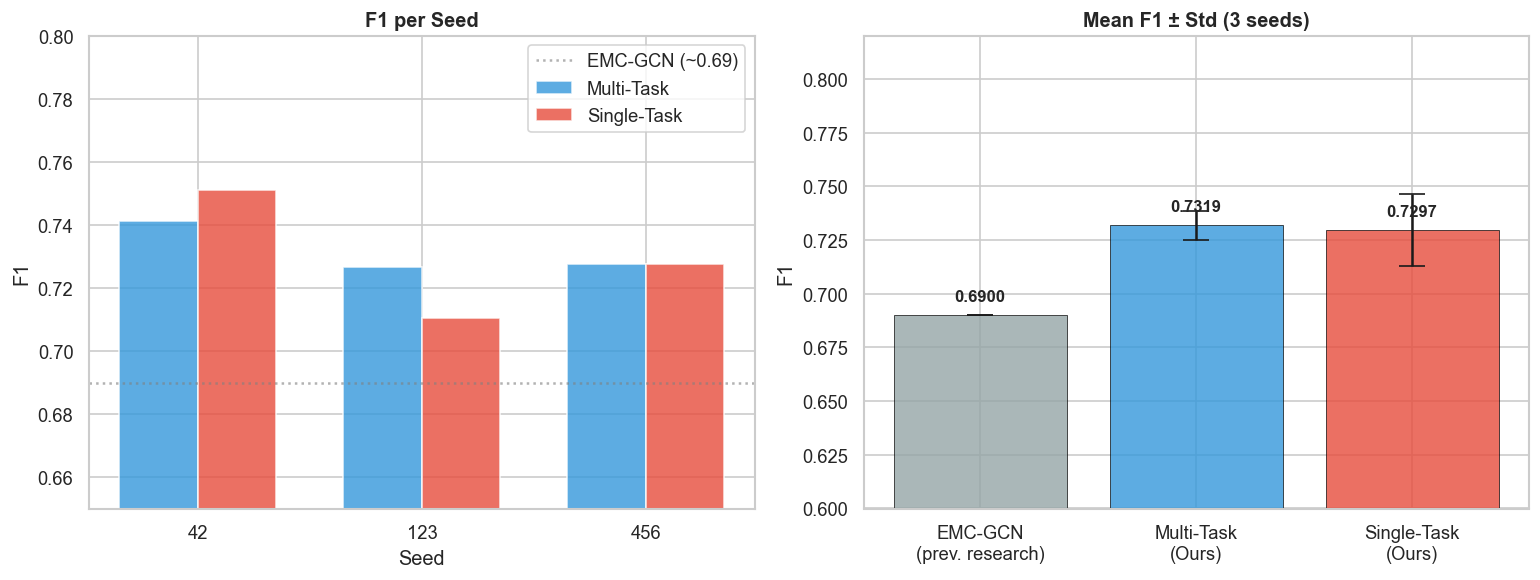

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Bar chart
x = np.arange(len(SEEDS))
width = 0.35
bars1 = axes[0].bar(x - width/2, mt_f1s, width, label='Multi-Task', color='#3498db', alpha=0.8)
bars2 = axes[0].bar(x + width/2, st_f1s, width, label='Single-Task', color='#e74c3c', alpha=0.8)
axes[0].axhline(0.69, color='gray', linestyle=':', alpha=0.6, label='EMC-GCN (~0.69)')
axes[0].set_xlabel('Seed')
axes[0].set_ylabel('F1')
axes[0].set_title('F1 per Seed', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([str(s) for s in SEEDS])
axes[0].legend()
axes[0].set_ylim(0.65, 0.80)

# Mean ± Std with EMC-GCN reference
models = ['EMC-GCN\n(prev. research)', 'Multi-Task\n(Ours)', 'Single-Task\n(Ours)']
means = [0.69, mt_mean, st_mean]
stds = [0, mt_std, st_std]
colors = ['#95a5a6', '#3498db', '#e74c3c']

bars = axes[1].bar(models, means, yerr=stds, capsize=8, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
for bar, mean in zip(bars, means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{mean:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
axes[1].set_ylabel('F1')
axes[1].set_title('Mean F1 ± Std (3 seeds)', fontweight='bold')
axes[1].set_ylim(0.60, 0.82)

plt.tight_layout()
plt.show()

### 9. PER-CLASS COMPARISON (best seed)

In [10]:
# Find seed with best multi-task result
best_mt_idx = np.argmax(mt_f1s)
best_seed = SEEDS[best_mt_idx]

print(f'Per-class reports for seed={best_seed} (best multi-task):')

print(f'\n--- Multi-Task (F1={mt_f1s[best_mt_idx]:.4f}) ---')
print(all_results['multi_task'][best_mt_idx]['report'])

print(f'--- Single-Task (F1={st_f1s[best_mt_idx]:.4f}) ---')
print(all_results['single_task'][best_mt_idx]['report'])

Per-class reports for seed=42 (best multi-task):

--- Multi-Task (F1=0.7413) ---
              precision    recall  f1-score   support

         NEG       0.60      0.59      0.59        83
         NEU       0.53      0.60      0.56       125
         POS       0.80      0.82      0.81       536

   micro avg       0.73      0.76      0.74       744
   macro avg       0.64      0.67      0.65       744
weighted avg       0.73      0.76      0.74       744

--- Single-Task (F1=0.7511) ---
              precision    recall  f1-score   support

         NEG       0.68      0.64      0.66        83
         NEU       0.54      0.66      0.59       125
         POS       0.78      0.84      0.80       536

   micro avg       0.72      0.78      0.75       744
   macro avg       0.66      0.71      0.69       744
weighted avg       0.72      0.78      0.75       744



### 10. SIMPAN HASIL

In [11]:
checkpoint = {
    'seeds': SEEDS,
    'results': all_results,
    'summary': {
        'multi_task': {'mean': mt_mean, 'std': mt_std, 'per_seed': mt_f1s},
        'single_task': {'mean': st_mean, 'std': st_std, 'per_seed': st_f1s},
        'emcgcn_reference': 0.69,
    },
    'config': {
        'model_name': MODEL_NAME,
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'lr_bert': LR_BERT,
        'lr_head': LR_HEAD,
        'batch_size': BATCH_SIZE * GRADIENT_ACCUMULATION,
        'multi_task_lambda': f'{LAMBDA1}/{LAMBDA2}',
        'phase1_epochs': PHASE1_EPOCHS,
        'total_data': len(raw_data),
    },
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_multiseed.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')
print(f'\nFinal: MT={mt_mean:.4f}±{mt_std:.4f} | ST={st_mean:.4f}±{st_std:.4f}')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_multiseed.pt
File size: 0.2 MB

Final: MT=0.7319±0.0067 | ST=0.7297±0.0166
